In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import math
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

xpath='/kaggle/input/sentinel1-sar-images-turkey/Turkey/img_dir'
ypath='/kaggle/input/sentinel1-sar-images-turkey/Turkey/ann_dir'
trn_hist_path='/home/20bce131/model/train_hist/'
trn_out_path='/home/20bce131/model/trn_imgs_out'
val_out_path='/home/20bce131/model/val_imgs_out'

batch_size = 32
num_epochs = 25
learning_rate=1e-2
gamma = 0.9
decay_steps = 10

In [9]:
def visualize_sample(img, label, title, path=''):
    label = tf.transpose(label, perm=[2,0,1])
    fig, ax = plt.subplots(1, 6, figsize=(20,20))
    for i, subplot_ax in zip(range(5 + 1), ax.flatten()):
        if i == 0: 
            subplot_ax.imshow(img)
            subplot_ax.set_title(title)
        else:
            subplot_ax.imshow(label[i-1], cmap='gray', vmin=0, vmax=1)
            subplot_ax.set_title(f'Label {i}')
    if path != '':
        plt.savefig(f'{path}/{title}.png')
    
def get_iou(preds, label):
    classwise_iou = []
    num_classes = 5
    preds = tf.argmax(preds, axis=-1)
    label = tf.argmax(label, axis=-1)
    for c in range(num_classes):
        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(label, c), tf.equal(preds, c)), dtype=tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(label, c), tf.equal(preds, c)), dtype=tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(label, c), tf.not_equal(preds, c)), dtype=tf.float32))
        iou = tp / (tp + fn + fp)
        if tf.math.is_nan(iou): continue
        classwise_iou.append(iou)
    classwise_iou = tf.stack(classwise_iou)
    miou = tf.reduce_mean(classwise_iou)
    return miou

def get_sample_from_val(idx):
    idx_num = idx % batch_size
    batch_num = int((idx-idx_num) / batch_size)
    imgs, labels = val.__getitem__(batch_num)
    img, label = imgs[idx_num], labels[idx_num]
    return img, label

In [10]:
class Train(tf.keras.utils.Sequence):
    def __init__(self, imgs, batch_size=batch_size):
        self.num_classes = 5
        self.height, self.width = 256, 256
        self.xtrain_path = xpath
        self.ytrain_path = ypath
        self.imgs = imgs
        self.batch_size = batch_size
        
        self.xtrain = []
        self.ytrain = []
        for img_name in self.imgs:
            xtrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.xtrain_path, img_name), target_size=(self.height, self.width)
            )
            xtrain = tf.keras.preprocessing.image.img_to_array(xtrain)
            self.xtrain.append(xtrain)

            ytrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.ytrain_path, img_name), target_size=(self.height, self.width),
                color_mode='grayscale'
            )
            ytrain = tf.keras.preprocessing.image.img_to_array(ytrain)
            ytrain = tf.squeeze(ytrain)
            ytrain = self.process_label(ytrain)
            ytrain = tf.transpose(ytrain, perm=[1,2,0])
            self.ytrain.append(ytrain)

        self.xtrain = tf.stack(self.xtrain)
        self.ytrain = tf.stack(self.ytrain)
        self.xtrain = self.xtrain / 255.0

    def __getitem__(self, idx):
        return self.xtrain[idx * self.batch_size : (idx + 1) * self.batch_size], self.ytrain[idx * self.batch_size : (idx + 1) * self.batch_size]

    def __len__(self):
        return math.ceil(len(self.imgs) / self.batch_size)
    
    def process_label(self, label):
        r = []
        for i in range(self.num_classes):
            mask = tf.cast(tf.equal(label, i+1), dtype=tf.float32)
            r.append(mask)
        return tf.stack(r)
    
class Validate(tf.keras.utils.Sequence):
    def __init__(self, imgs, batch_size=batch_size):
        self.num_classes = 5
        self.height, self.width = 256, 256
        self.xtrain_path = xpath
        self.ytrain_path = ypath
        self.imgs = imgs
        self.batch_size = batch_size
        
        self.xtrain = []
        self.ytrain = []
        for img_name in self.imgs:
            xtrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.xtrain_path, img_name), target_size=(self.height, self.width)
            )
            xtrain = tf.keras.preprocessing.image.img_to_array(xtrain)
            self.xtrain.append(xtrain)

            ytrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.ytrain_path, img_name), target_size=(self.height, self.width),
                color_mode='grayscale'
            )
            ytrain = tf.keras.preprocessing.image.img_to_array(ytrain)
            ytrain = tf.squeeze(ytrain)
            ytrain = self.process_label(ytrain)
            ytrain = tf.transpose(ytrain, perm=[1,2,0])
            self.ytrain.append(ytrain)

        self.xtrain = tf.stack(self.xtrain)
        self.ytrain = tf.stack(self.ytrain)
        self.xtrain = self.xtrain / 255.0

    def __getitem__(self, idx):
        return self.xtrain[idx * self.batch_size : (idx + 1) * self.batch_size], self.ytrain[idx * self.batch_size : (idx + 1) * self.batch_size]

    def __len__(self):
        return math.ceil(len(self.imgs) / self.batch_size)
    
    def process_label(self, label):
        r = []
        for i in range(self.num_classes):
            mask = tf.cast(tf.equal(label, i+1), dtype=tf.float32)
            r.append(mask)
        return tf.stack(r)

In [11]:
imgs = np.array(os.listdir(xpath))[:1000]
train_imgs, val_imgs = train_test_split(imgs, test_size=0.2)
train = Train(train_imgs)
val = Validate(val_imgs)

In [12]:
def double_conv(in_channels, out_channels):
    conv = tf.keras.Sequential([
        layers.Conv2D(filters=out_channels, kernel_size=3, strides=1, padding='same'),
        layers.ReLU(),
        layers.Dropout(rate=0.4),
        layers.Conv2D(filters=out_channels, kernel_size=3, strides=1, padding='same'),
        layers.ReLU(),
        layers.BatchNormalization()
    ])
    return conv

def double_Tconv(in_channels, out_channels):
    Tconv = tf.keras.Sequential([
        layers.Conv2DTranspose(filters=out_channels, kernel_size=3, strides=1, padding='same'),
        layers.ReLU(),
        layers.Dropout(rate=0.4),
        layers.Conv2DTranspose(filters=out_channels, kernel_size=3, strides=1, padding='same'),
        layers.ReLU(),
        layers.BatchNormalization()
    ])
    return Tconv

class Network(tf.keras.Model):
    def __init__(self):
        super(Network, self).__init__()
        self.max_pool = layers.MaxPool2D(pool_size=2, strides=2, padding='same')
        self.upsample = tf.keras.layers.UpSampling2D()
        self.conv1 = double_conv(3, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)
        self.conv5 = double_conv(512, 1024)
        self.Tconv5 = double_Tconv(1024, 512)
        self.Tconv4 = double_Tconv(512, 256)
        self.Tconv3 = double_Tconv(256, 128)
        self.Tconv2 = double_Tconv(128, 64)
        self.Tconv1 = double_Tconv(64, 5)
        self.dropout = layers.Dropout(rate=0.25)
        self.softmax = layers.Softmax(axis=3)
    
    def call(self, inputs):
        c1 = self.conv1(inputs)
        x1 = self.max_pool(c1)

        c2 = self.conv2(x1)
        x2 = self.max_pool(c2)
        
        c3 = self.conv3(x2)
        x3 = self.max_pool(c3)

        c4 = self.conv4(x3)
        x4 = self.max_pool(c4)
        
        i = self.conv5(x4)
        
        i = self.dropout(i)
        
        t4 = self.Tconv5(i)
    
        z4 = tf.concat([self.upsample(t4), c4], axis=-1)
        t3 = self.Tconv4(z4)
        
        z3 = tf.concat([self.upsample(t3), c3], axis=-1)
        t2 = self.Tconv3(z3)
    
        z2 = tf.concat([self.upsample(t2), c2], axis=-1)
        t1 = self.Tconv2(z2)
        
        z1 = tf.concat([self.upsample(t1), c1], axis=-1)
        out = self.Tconv1(z1)
        
        return self.softmax(out)

In [13]:
model = Network()
model.build(input_shape=(batch_size,256,256,3))

In [14]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps=decay_steps,
    decay_rate=gamma,
    staircase=True
)
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optim, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(train, steps_per_epoch=train.__len__(), epochs=num_epochs, validation_data=val)

Epoch 1/25


2023-06-30 06:10:19.283067: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape innetwork_1/sequential_10/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 47s 805ms/step - loss: 1.2446 - accuracy: 0.5606 - val_loss: 31458.7148 - val_accuracy: 0.0017
Epoch 2/25
25/25 [==============================] - 18s 716ms/step - loss: 0.8671 - accuracy: 0.7523 - val_loss: 486.1335 - val_accuracy: 0.0268
Epoch 3/25
25/25 [==============================] - 18s 714ms/step - loss: 0.7697 - accuracy: 0.7706 - val_loss: 22.7285 - val_accuracy: 0.2589
Epoch 4/25
25/25 [==============================] - 18s 713ms/step - loss: 0.7157 - accuracy: 0.7803 - val_loss: 3.4418 - val_accuracy: 0.4304
Epoch 5/25
25/25 [==============================] - 19s 763ms/step - loss: 0.6969 - accuracy: 0.7795 - val_loss: 1.3117 - val_accuracy: 0.6631
Epoch 6/25
25/25 [==============================] - 18s 711ms/step - loss: 0.6761 - accuracy: 0.7827 - val_loss: 0.9351 - val_accuracy: 0.6899
Epoch 7/25
25/25 [==============================] - 18s 717ms/step - loss: 0.6540 - accuracy: 0.7889 - val_loss: 0.8446 - val_accuracy: 0.7065
Epo

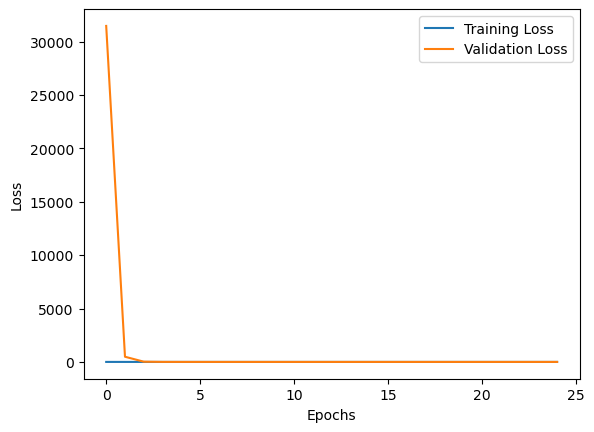

<Figure size 640x480 with 0 Axes>

In [15]:
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.clf()

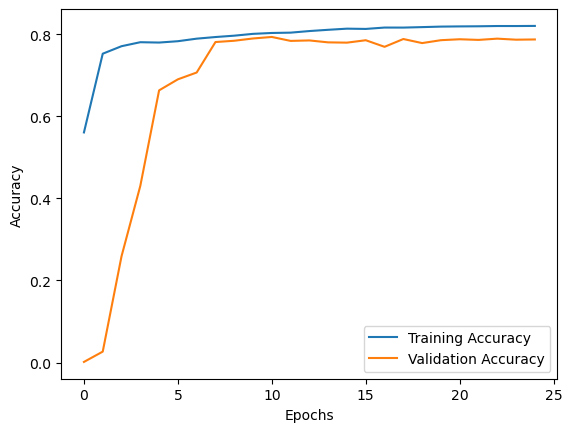

In [16]:
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [17]:
preds = model.predict(val)
iou = get_iou(preds, val.ytrain)
print(f'Mean IoU : {iou}')

7/7 [==============================] - 2s 178ms/step
Mean IoU : 0.4815685749053955


[ 8 61 27 63 12]
1/1 [==============================] - 0s 40ms/step


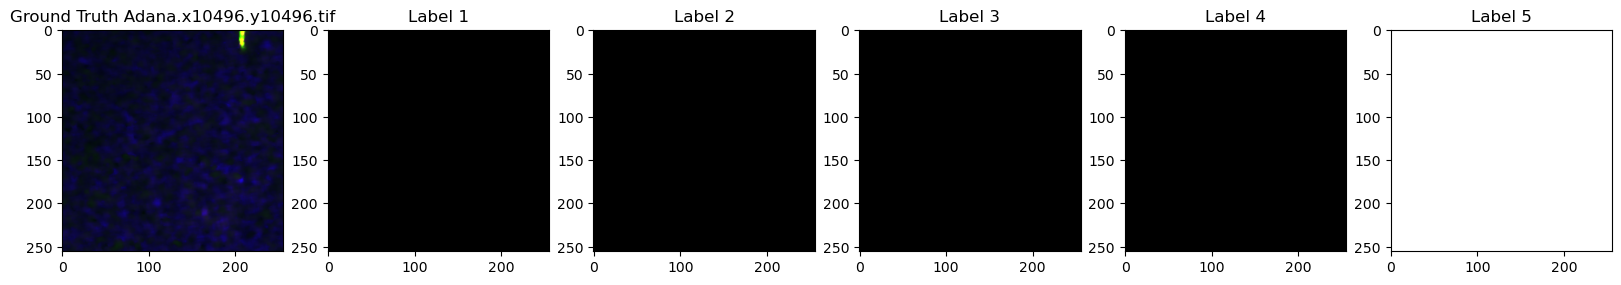

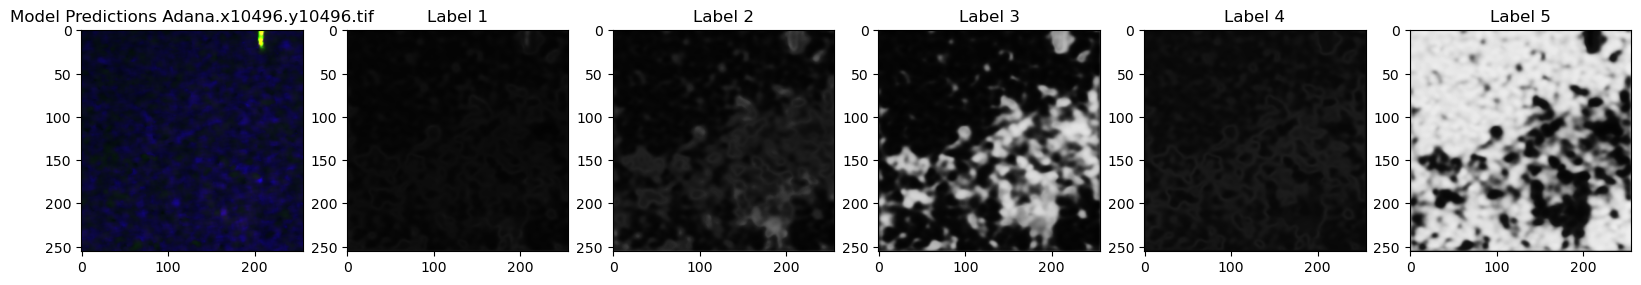

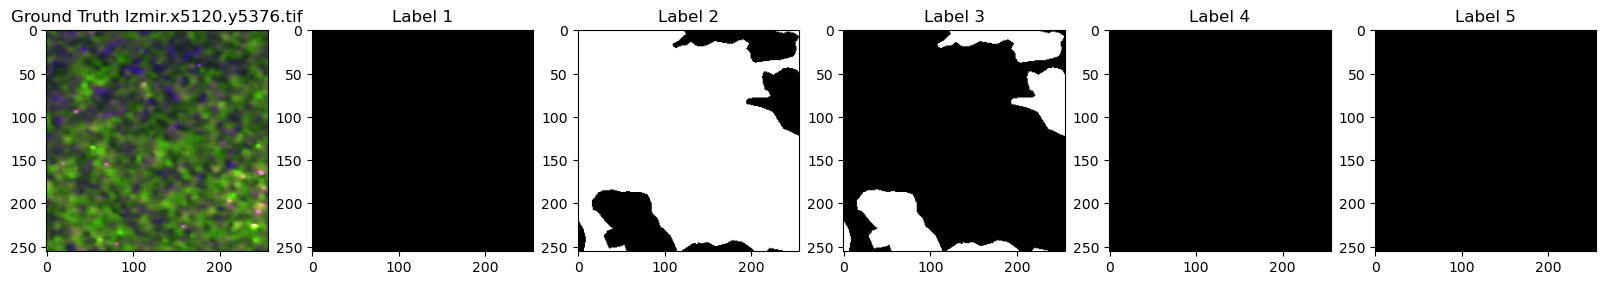

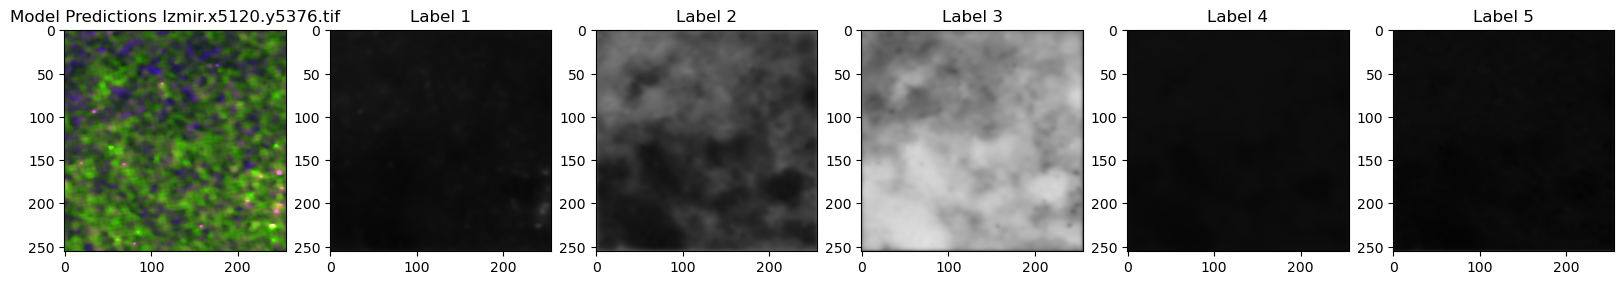

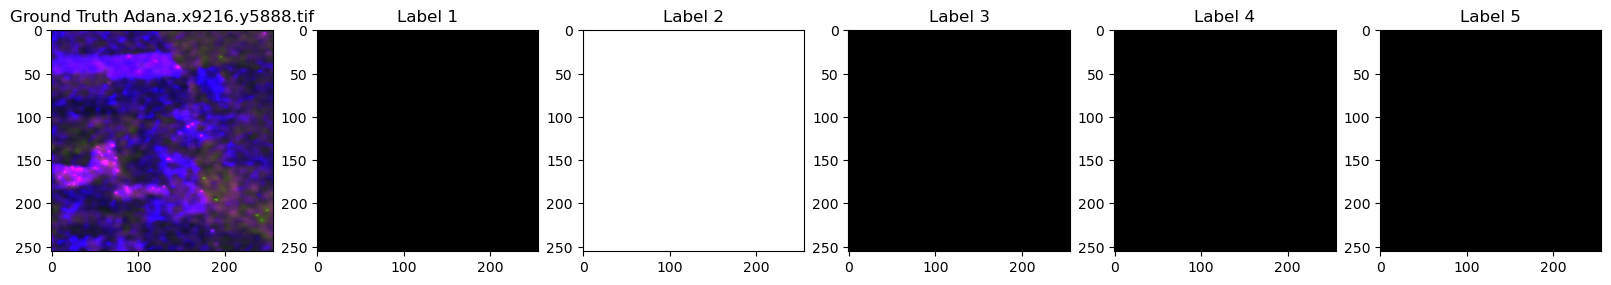

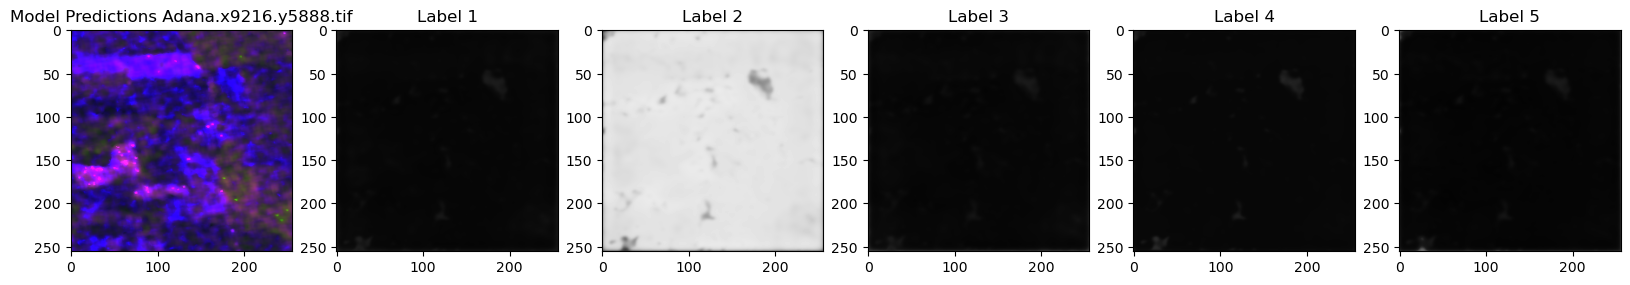

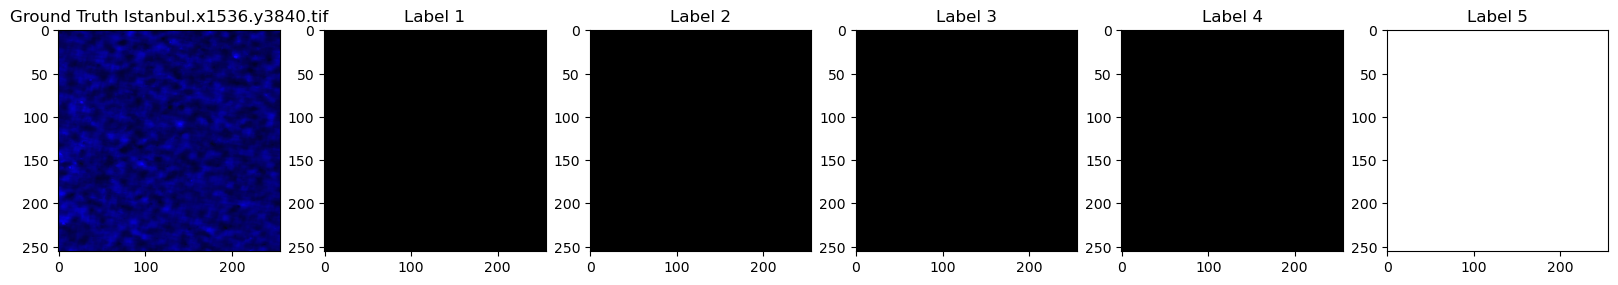

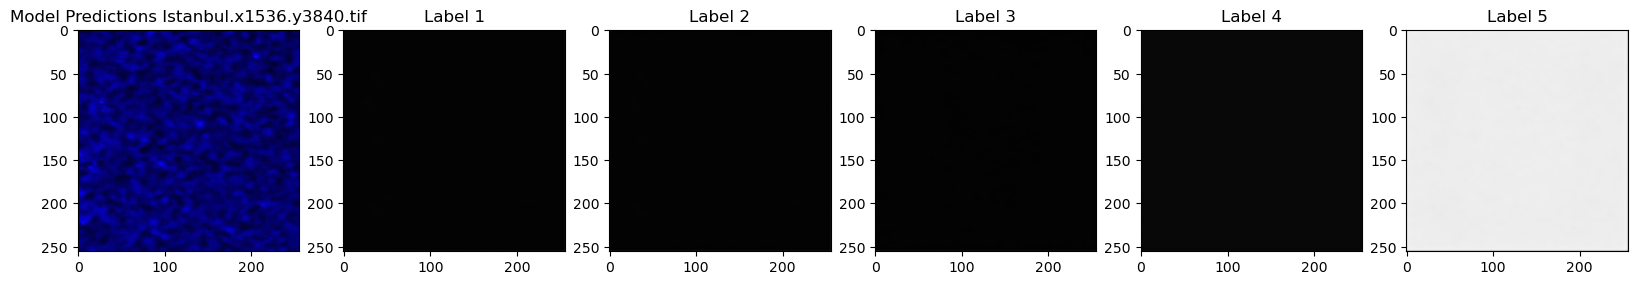

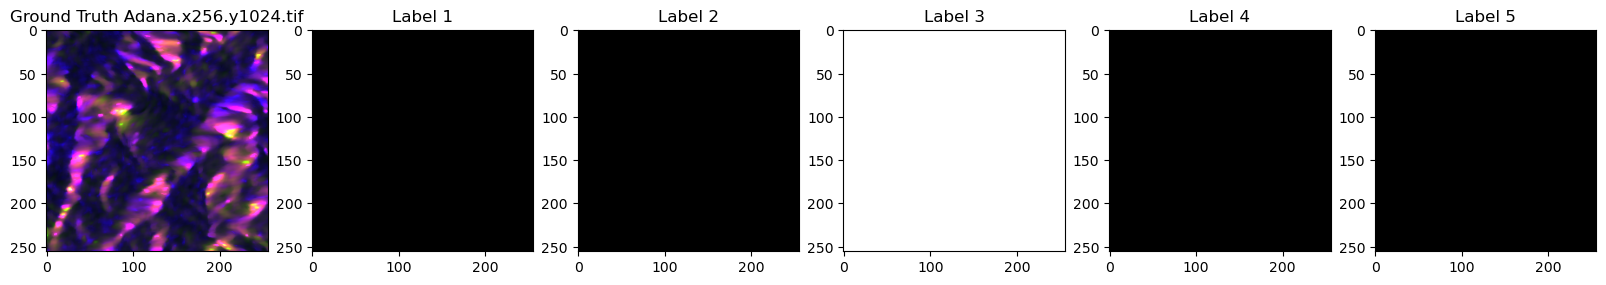

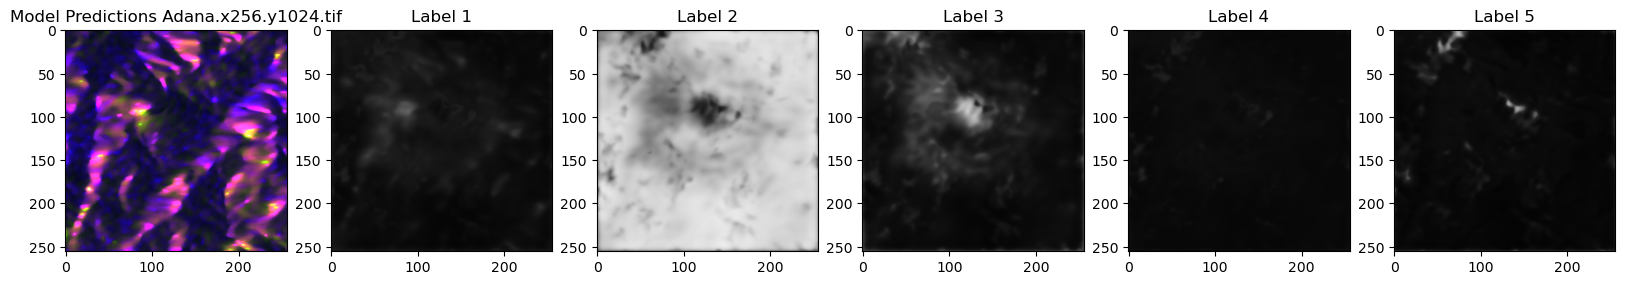

In [19]:
idxs = np.random.randint(0, len(val)*batch_size+1, (5,))
print(idxs)
for i in idxs:
    img, label = get_sample_from_val(i)
    visualize_sample(img, label, f'Ground Truth {val_imgs[i]}')
    pred = model.predict(tf.expand_dims(img, axis=0))
    visualize_sample(img, tf.squeeze(pred), f'Model Predictions {val_imgs[i]}')